##### <h1 style="color:Green;">Week 4 Lecture Source Code</h1> 

<a style="color:purple;" href="https://docs.google.com/presentation/d/1_jQKSrS4hiVJaxnFYhRh284AhAbPxI0CL0qAP4Iz-DE/edit#slide=id.p">[Week 4 Lecture Link Here]</a>

<h2 style="color:Green;">Setup and Loading Packages</h2> Setup and Loading Packages

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_multilabel_classification
import pandas_datareader as pdr

What is Classification?

Classification is a supervised learning concept that uses one or more predictors (features, independent variables) to categorize a set of data into classes. This concept can be applied to solve two-class or multi-class calssification problems, in real-world scenarios such as:

• Identifying economic cycles (e.g., expansion, peak, through, recession)

• Classifying credit card transactions as legitimate or fraudulent

• Classifying market strend structures as uptrend, congestion, downtrend

• Categorizing news stories of finance as having positive, neutral, or negative sentiments

• Recognizing handwritten checks and digits as one of {A, B, C, …, Z, 0, 1, ... 9}

• Assigning trading attributes to their origin of cause (e.g., Greece, UK, Russia)


Note that different assumptiosn are made for each classification model.

<h2 style="color:Green;">Simulated Data (pg. 3)</h2>

<b> Example of a Binary Classification Problem </b>

Let's use the data we processed from last lecture. This contains sector ETFs, XLK (Technology) and IYC (Consumer Discretionary), as well as SPY (S&P 500) directions from 1/25/2018 to 5/31/2022, a total of 1086 trading days.

In [62]:
DATA1 = pd.read_csv('SPY_XLK_IYC.csv')
DATA1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086 entries, 0 to 1085
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1086 non-null   object 
 1   SPY     1086 non-null   float64
 2   XLK     1086 non-null   float64
 3   IYC     1086 non-null   float64
dtypes: float64(3), object(1)
memory usage: 34.1+ KB


In [64]:
# converting SPY log returns into binary values 1's and 0's
DATA1['SPY Direction'] = (DATA1.SPY > 0).astype(int)

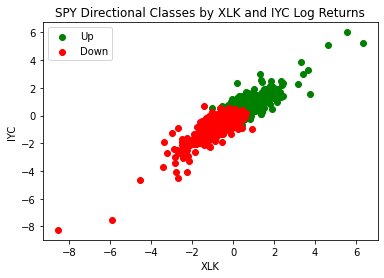

In [70]:
plt.scatter(DATA1.XLK[DATA1['SPY Direction'] == 1],
            DATA1.IYC[DATA1['SPY Direction'] == 1],
           color='green',
           label='Up')
plt.scatter(DATA1.XLK[DATA1['SPY Direction'] == 0],
            DATA1.IYC[DATA1['SPY Direction'] == 0],
           color='red',
           label='Down')
plt.title('SPY Directional Classes by XLK and IYC Log Returns')
plt.xlabel('XLK')
plt.ylabel('IYC')
plt.legend()
plt.show()

From the scatter plot, besides a fairly strong linear relationship, we can see that the data points are divided into red and green colors, green representing an upward direction in SPY and red represeneting a downward direction in SPY. One of the most popular problems in quantitative finance is to find a classifier (model) that most-accurately separates the data points that indicates an upward move from those that indicate a downward move. Through this model, we will be able to predict under any given conditions of XLK and IYC log returns, which direction would SPY be expected to move in the next trading day. 

<b> Example of a Multi-class Classification Problem </b>

Note that here, we split the data by their quantiles just so each of the 4 classes can dominate roughly 25% of the data set, hence making the data set less biased and eliminating the label imbalance issue.

In [88]:
# categorizing SPY returns into 2 directional classes
multiInterval = [DATA1.SPY.min(), DATA1.SPY.quantile(.25), 0, DATA1.SPY.quantile(.75), DATA1.SPY.max()]
multiLabels   = ['major loss','minor loss','minor gain','major gain']
DATA1['SPY Return Type'] = pd.cut(DATA1.SPY, bins = multiInterval, labels=multiLabels)

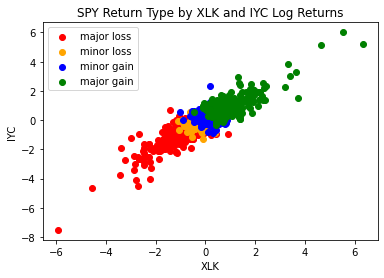

In [78]:
plt.scatter(DATA1.XLK[DATA1['SPY Return Type'] == 'major loss'],
            DATA1.IYC[DATA1['SPY Return Type'] == 'major loss'],
           color='red',
           label='major loss')
plt.scatter(DATA1.XLK[DATA1['SPY Return Type'] == 'minor loss'],
            DATA1.IYC[DATA1['SPY Return Type'] == 'minor loss'],
           color='orange',
           label='minor loss')
plt.scatter(DATA1.XLK[DATA1['SPY Return Type'] == 'minor gain'],
            DATA1.IYC[DATA1['SPY Return Type'] == 'minor gain'],
           color='blue',
           label='minor gain')
plt.scatter(DATA1.XLK[DATA1['SPY Return Type'] == 'major gain'],
            DATA1.IYC[DATA1['SPY Return Type'] == 'major gain'],
           color='green',
           label='major gain')

plt.title('SPY Return Type by XLK and IYC Log Returns')
plt.xlabel('XLK')
plt.ylabel('IYC')
plt.legend()
plt.show()

This is a multi-class classification problem, one that consists of > 2 SPY return type classes. Be aware that we are no longer evaluating the asset's directional, but rather the magnitude of its daily gains/losses. Our goall is fond the classifier (model) of multiple lines that most-accurately separate the SPY return type into their corresponding classes.

<h2 style="color:Green;">Exploring the Trading Factors Data (pg. XX)</h2>

Here, we examine the trading signals of the top 500 most-traded stock in the U.S. from 1/21/2013 to 9/30/2017. This data set was originally used to indicate market behaviors in the U.S. during the European struggles such as the Greece's debt crisis in 2015 and Brexit in 2017. One of the behaviors is the fluctuation of market participants, and a way to measure this is through trading volumes, in other words, the transactions of assets throughout a period in time. In our case, we will be looking at monthly volumes, specifically how they are classified to imply low, medium, or high liquidity. 


Our goal is to use the trading factors to help train the classification models to predict market liquidity. The utilization of this is to inform the concentration of the selected market a trader is trading in. We start by loading the data set and categorizing volumes into 3 respective liquidity classes.

In [6]:
DATA2 = pd.read_csv('trading_factors_data.csv')
DATA2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31435 entries, 0 to 31434
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sector     31435 non-null  object 
 1   atr        31435 non-null  float64
 2   macd       31435 non-null  float64
 3   rsi        31435 non-null  float64
 4   bb_mid     31435 non-null  float64
 5   bb_upper   31435 non-null  float64
 6   bb_lower   31435 non-null  float64
 7   liquidity  31435 non-null  object 
dtypes: float64(6), object(2)
memory usage: 1.9+ MB


Standardizing numerical indictors in the data set.

In [7]:
LABEL = 'liquidity'
FEATURES = DATA2.columns
FEATURES = [f for f in FEATURES if f not in ['liquidity','sector']]

In [8]:
DATA2.loc[:, FEATURES] = scale(DATA2.loc[:, FEATURES]) # standardizing indicators

Create dummy variables to covert sector categories into numerical ones.

In [9]:
# get the dummies and store it in a variable
dummies = pd.get_dummies(DATA2.sector)

# Concatenate the dummies to original dataframe
merged = pd.concat([DATA2, dummies], axis='columns')
    
# drop the values
DATA2 = merged.drop(['sector'], axis='columns')

# See data info
DATA2.head()

,atr,macd,rsi,bb_mid,bb_upper,bb_lower,liquidity,Basic Industries,Capital Goods,Consumer Durables,Consumer Non-Durables,Consumer Services,Energy,Finance,Health Care,Miscellaneous,Public Utilities,Technology,Transportation
0,-1.392712,1.079815,1.008666,-0.695295,-0.716651,-0.672630,Medium,0,1,0,0,0,0,0,0,0,0,0,0
1,-0.084627,0.348207,-0.197922,-0.409229,-0.417685,-0.399921,Medium,0,0,0,0,0,0,0,0,0,0,0,1
2,-1.592250,0.071391,-0.252138,0.390414,0.363185,0.416133,Low,0,0,0,0,1,0,0,0,0,0,0,0
3,0.009927,-1.841691,-1.416073,0.230941,0.324129,0.139020,High,0,0,0,0,0,0,0,0,0,0,1,0
4,-1.302958,0.229371,0.685063,-0.307687,-0.329960,-0.285088,Medium,0,0,0,0,0,0,0,1,0,0,0,0


As an example, we have ploted the stocks' liquidity class by the indicators macd vs bb_mid.

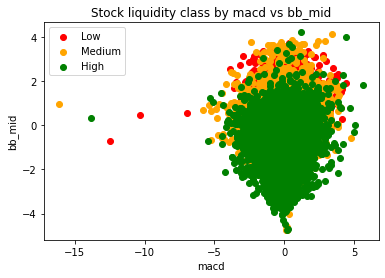

In [10]:
plt.scatter(DATA2['macd'][DATA2.liquidity == 'Low'],
            DATA2['bb_mid'][DATA2.liquidity == 'Low'],
           color='red',
           label='Low')
plt.scatter(DATA2['macd'][DATA2.liquidity == 'Medium'],
            DATA2['bb_mid'][DATA2.liquidity == 'Medium'],
           color='orange',
           label='Medium')
plt.scatter(DATA2['macd'][DATA2.liquidity == 'High'],
            DATA2['bb_mid'][DATA2.liquidity == 'High'],
           color='green',
           label='High')

plt.title('Stock liquidity class by macd vs bb_mid')
plt.xlabel('macd')
plt.ylabel('bb_mid')
plt.legend()
plt.show()

Splitting data into 80% training set and 20% testing set.

In [11]:
FEATURES = FEATURES+dummies.columns.to_list()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(DATA2.loc[:, FEATURES], DATA2.loc[:, LABEL], test_size=0.2, random_state=0)

<b>Feature Importance</b>

In [13]:
from sklearn.ensemble import RandomForestClassifier # importing the random forest module

rf_model = RandomForestClassifier(random_state=0) # define the random forest model

rf_model.fit(X_train, y_train) # fit the random forest model

importances = rf_model.feature_importances_ # get importance

indices = np.argsort(importances) # sort the features' index by their importance scores

Ranking features by thier relative importance scores.

Text(0.5, 0, 'Relative Importance')

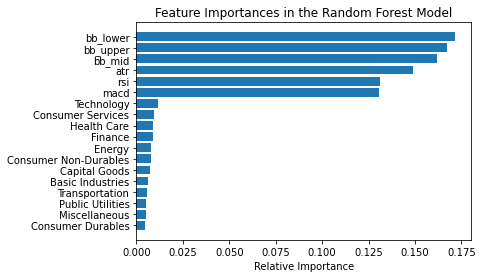

In [14]:
plt.title('Feature Importances in the Random Forest Model')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [FEATURES[i] for i in indices])
plt.xlabel('Relative Importance')

Let's keep the features with importance scores of at least 0.05. These will be bb_lower, bb_upper, bb_mid, atr, rsi, and macd . Then, we drop the remaining features with less significant scores. 

In [15]:
FEATURES_TO_DROP=[FEATURES[i] for i in indices[importances[indices] < 0.05]]

In [16]:
DATA2 = DATA2.drop(columns=FEATURES_TO_DROP) # drop feature in the original data set
X_train = X_train.drop(columns = FEATURES_TO_DROP) # drop feature in the training data set
X_test = X_test.drop(columns= FEATURES_TO_DROP) # drop feature in the testing data set
FEATURES = [f for f in FEATURES if f not in FEATURES_TO_DROP] 

<b>Multicollinearity</b>

We use VIF to test for multicollinearity since the remaining features are numerical; if the features are categorical, we would use Chi-square test to test for correlation. At first we found bb_mid, bb_upper, and bb_lower have inf values, which iindicates an R squared of 1 and a perfect correlation. 

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
VIF = [variance_inflation_factor(DATA2.loc[:, FEATURES].values, i) for i in range(len(FEATURES))]
VIF_table = pd.DataFrame({'Features': FEATURES, 'VIF': VIF})
VIF_table

C:\Users\user\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Features,VIF
0,atr,1.18631
1,macd,2.69763
2,rsi,2.69259
3,bb_mid,inf
4,bb_upper,inf
5,bb_lower,inf


To resolve this problem, let's keep just the bb_mid feature and discard bb_upper and bb_lower. The result shows low VIF values for this set of features because they are all < 5. Since they are not considered to have high correlations, we will keep them as our final predictors for the liquidity strength.

In [20]:
FEATURES = [f for f in FEATURES if f not in ['bb_upper', 'bb_lower']]

In [21]:
VIF = [variance_inflation_factor(DATA2.loc[:, FEATURES].values, i) for i in range(len(FEATURES))]
VIF_table = pd.DataFrame({'Features': FEATURES, 'VIF': VIF})
VIF_table

,Features,VIF
0,atr,1.095002
1,macd,2.686477
2,rsi,2.688805
3,bb_mid,1.076711


<b>Label Imbalance</b>

Let's investigate whether there is a label imbalance issue. We count the number of observations with High, Medium, and Low liquidity, then plotted them using a barplot. The minority-to-majority ratio of SPY directions matches about a 2:1:1 ratio or 50% samples in the Medium class and 25% samples in the High and Low classes. 

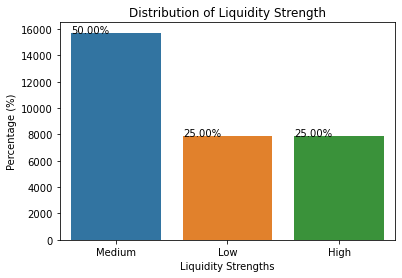

In [22]:
ax = sns.countplot(x = "liquidity", data = DATA2)
plt.title('Distribution of Liquidity Strength')
plt.xlabel('Liquidity Strengths')
plt.ylabel('Frequency')
total = len(DATA2["liquidity"])
for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        x_coord = p.get_x() 
        y_coord = p.get_y() + p.get_height()+0.02
        ax.annotate(percentage, (x_coord, y_coord))

This is not a well-balanced data set, so let's rebalanced the labels using SMOTE!!

Text(0, 0.5, 'Frequency')

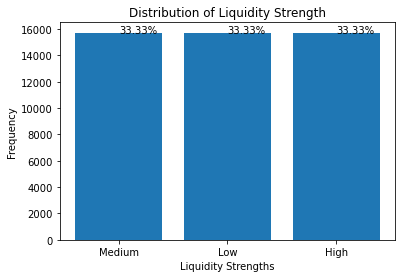

In [28]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder    

fig, ax = plt.subplots()
# split into input and output elements
X_SMOTE, y_SMOTE = DATA2.loc[:, FEATURES], DATA2.loc[:, LABEL]
# label encode the target variable (2=Medium, 1=Low, 0=High)
y_SMOTE = LabelEncoder().fit_transform(y_SMOTE) 
# transform the dataset
oversample = SMOTE()
X_SMOTE, y_SMOTE = oversample.fit_resample(X_SMOTE, y_SMOTE)
# summarize distribution
counter = Counter(y_SMOTE)
# plot the distribution
counter.items()
ax.bar(['Medium','Low','High'], counter.values())
# annotate class percentages
for x in counter.keys():
    ax.annotate('{:.2f}%'.format(100 * counter[x]/sum(counter.values())), (x, counter[x]))
plt.title('Distribution of Liquidity Strength')
plt.xlabel('Liquidity Strengths')
plt.ylabel('Frequency')

SMOTE automatically helps us upsample the minority classes (the Low and High classes), so now all three classes have the same probability of being selected, and most importantly, well-balanced. Of course, we can also use the RandomUnderSampler() class function instead to downs-sample the majority class.